In [1]:
import tensorflow as tf
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt

In [2]:
import os, glob
import shutil
import pathlib
import scipy.io
import mat73
import tqdm
import random

In [3]:
%pwd

'/data03/team01/sidd/medium'

In [4]:
# %mkdi

In [5]:
%ls -la

total 484624
drwxrwxr-x 12 1000 1000      4096 Sep 14 04:32  ./
drwxrwxr-x  5 1000 1000      4096 Sep  5 23:49  ../
drwxr-xr-x  2 1000 1000      4096 Sep  7 13:54  .ipynb_checkpoints/
-rw-rw-r--  1 1000 1000 259434382 Sep 12 01:18  BenchmarkNoisyBlocksRaw.mat
-rw-rw-r--  1 1000 1000 231822939 Sep 12 01:18  BenchmarkNoisyBlocksSrgb.mat
drwxrwxr-x 42 1000 1000      4096 Sep 12 01:15  SIDD_Benchmark_Data/
drwxrwxr-x  3 1000 1000      4096 Sep  5 23:53  SIDD_Medium_Raw/
drwxrwxr-x  3 1000 1000      4096 Sep  5 23:55  SIDD_Medium_Srgb/
drwxrwxr-x  2 1000 1000      4096 Sep 12 02:36  SIDD_Validation/
-rw-r--r--  1 1000 1000   4148569 Sep 13 16:53 'data extractor.ipynb'
-rw-r--r--  1 1000 1000    555992 Sep  7 14:21  sidd_data_alnalysis.ipynb
-rw-r--r--  1 1000 1000    200527 Sep 14 04:32  sidd_tfrecords.ipynb
drwxrwxr-x  2 1000 1000      4096 Sep 14 04:32  tfrecords/
drwxrwxr-x  2 1000 1000     32768 Sep 14 04:18  tfrecords_cut/
drwxrwxr-x  4 1000 1000      4096 Sep  6 16:59  tot/
drwxrwxr-x

# 011

In [6]:
dir_name = 'tot_cut'
files = glob.glob(os.path.join(dir_name, '011', '*'))
len(files)

1120

In [7]:
files.sort()
files = [f for f in files if '.npy' in f or '.PNG' in f ]
# for f in files:
#     print(f)

lenfiles = len(files) // 4

orders = list(range(lenfiles))
# random.shuffle(orders)
len(orders)

    

    

160

In [8]:
orders

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159]

In [9]:

def write_tfrecords(arr_x, arr_y, tag, idx_split, dataset_name, output_path, patch_size=128): 
    # tag: noisy_srgb, noisy_raw, gt_srgb, gt_raw


    tfrecords_name = '%s_%s_%04d.tfrecords' % (dataset_name, tag, idx_split)
    tfrecords_name = os.path.join(output_path, tfrecords_name)

    if os.path.isfile(tfrecords_name):
        print('OHNO -->. tfrecord (%s) exists' % tfrecords_name)
#         return

#     print('tfrecord not exists')
#     print('--->', tfrecords_name)
    
    arr_x = arr_x[..., np.newaxis]
    
#     print(arr_x.shape, ' vs ', arr_y.shape)
    assert len(arr_x.shape) == len(arr_y.shape)
    
    shape = arr_x.shape
    
    writer = tf.io.TFRecordWriter(tfrecords_name)
    
    cnt=0
    
    for idxy in range(0, shape[0]-patch_size, patch_size):
        for idxx in range(0, shape[1]-patch_size, patch_size):
            cnt+=1
            
            xp = arr_x[idxy:idxy+patch_size, idxx:idxx+patch_size,:]
            yp = arr_y[idxy:idxy+patch_size, idxx:idxx+patch_size,:]
            
            example = tf.train.Example(
                features=tf.train.Features(feature={
                    'raw': tf.train.Feature(
                            bytes_list=tf.train.BytesList(value=[xp.tostring()])
                            ),
                    'srgb': tf.train.Feature(
                            bytes_list=tf.train.BytesList(value=[yp.tostring()])
                            )
                })
            )
    
            writer.write(example.SerializeToString())
    writer.close()
    
    return cnt

     

In [10]:

cnt_g=0
cnt_n=0
for idx, order in  enumerate(tqdm.tqdm(orders)):
#     print(idx+1 , '/' ,  len(orders))
    
    idx = order*4
#     print(files[idx:idx+4])
    fname_gt_raw     = files[idx]
    fname_gt_srgb    = files[idx+1]
    fname_noisy_raw  = files[idx+2]
    fname_noisy_srgb = files[idx+3]
    
    gt_srgb    = Image.open(fname_gt_srgb)
    noisy_srgb = Image.open(fname_noisy_srgb)
    
    
    # convert as np array
    arr_gt_srgb    = np.array(gt_srgb)
    arr_gt_raw     = np.load(fname_gt_raw)
    arr_noisy_srgb = np.array(noisy_srgb)
    arr_noisy_raw  = np.load(fname_noisy_raw)
    
    # quantize to 16 bits
    arr_gt_raw = arr_gt_raw * (2**16 - 1)
    arr_gt_raw = arr_gt_raw.astype(np.uint16)
    
    arr_noisy_raw = arr_noisy_raw * (2**16 - 1)
    arr_noisy_raw = arr_noisy_raw.astype(np.uint16)
    
    
    # make all bayer patterns to GRBG
    
    tag = '-_-'
    if '_S6' in fname_gt_raw:
        tag = 'S6'
        pass
    elif '_IP' in fname_gt_raw:
        tag = 'IP'
        arr_gt_srgb    = arr_gt_srgb[:, 1:-1]
        arr_gt_raw     = arr_gt_raw[:, 1:-1]
        arr_noisy_srgb = arr_noisy_srgb[:, 1:-1]
        arr_noisy_raw  = arr_noisy_raw[:, 1:-1]
    elif '_GP' in fname_gt_raw:
        tag = 'GP'
        arr_gt_srgb    = arr_gt_srgb[1:-1, :]
        arr_gt_raw     = arr_gt_raw[1:-1, :]
        arr_noisy_srgb = arr_noisy_srgb[1:-1, :]
        arr_noisy_raw  = arr_noisy_raw[1:-1, :]
    elif '_N6' in fname_gt_raw:
        tag = 'N6'
        arr_gt_srgb    = arr_gt_srgb[1:-1, :]
        arr_gt_raw     = arr_gt_raw[1:-1, :]
        arr_noisy_srgb = arr_noisy_srgb[1:-1, :]
        arr_noisy_raw  = arr_noisy_raw[1:-1, :]
    elif '_G4' in fname_gt_raw:
        tag = 'G4'
        arr_gt_srgb    = arr_gt_srgb[1:-1, :]
        arr_gt_raw     = arr_gt_raw[1:-1, :]
        arr_noisy_srgb = arr_noisy_srgb[1:-1, :]
        arr_noisy_raw  = arr_noisy_raw[1:-1, :]
    else:
        print('unknown class')
        break
    
    
    # name
    num = files[idx].split('/')[-1]
#     print(num[:4])
    
    cnt_g += write_tfrecords(arr_x=arr_gt_raw, arr_y=arr_gt_srgb, tag='gt', idx_split=int(num[:4]), 
                    dataset_name='sidd_train_medium_'+tag, output_path='tfrecords')
    
    cnt_n += write_tfrecords(arr_x=arr_noisy_raw, arr_y=arr_noisy_srgb, tag='noisy', idx_split=int(num[:4]), 
                    dataset_name='sidd_train_medium_'+tag, output_path='tfrecords')
 
    
#     print(idx, " > ", np.amin(arr_gt_srgb), np.amax(arr_gt_srgb),       arr_gt_srgb.shape)
#     print(idx, " > ", np.amin(arr_gt_raw),  np.amax(arr_gt_raw),        arr_gt_raw.shape, np.unique(arr_gt_raw).shape)
#     print(idx, " > ", np.amin(arr_noisy_srgb), np.amax(arr_noisy_srgb), arr_noisy_srgb.shape)
#     print(idx, " > ", np.amin(arr_noisy_raw), np.amax(arr_noisy_raw),   arr_noisy_raw.shape, np.unique(arr_noisy_raw).shape)
    
      
    
#     break

print(cnt_g, cnt_n)

  0%|          | 0/160 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
100%|██████████| 160/160 [04:56<00:00,  1.85s/it]

127020 127020


In [10]:
%ls

 SIDD_Medium_Raw/        sidd_data_alnalysis.ipynb   tfrecords_cut/
 SIDD_Medium_Srgb/       sidd_tfrecords.ipynb        tot/
'data extractor.ipynb'   tfrecords/                  tot_cut/


In [12]:
a = np.arange(16).reshape(4,4)
a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [13]:
a[:, 1:-1]

array([[ 1,  2],
       [ 5,  6],
       [ 9, 10],
       [13, 14]])

In [14]:
a[1:-1, :]

array([[ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

# Benchmark

In [11]:
dir_name = 'tot_benchmark_cut'
files = glob.glob(os.path.join(dir_name, '*'))
len(files)

120

In [12]:
files.sort()
files = [f for f in files if '.npy' in f or '.PNG' in f ]
# for f in files:
#     print(f)

lenfiles = len(files) // 2

orders = list(range(lenfiles))
# random.shuffle(orders)
# for f in files:
#     print(f)
print(len(orders))

40


In [13]:
for o in orders:
    print(o, end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

In [15]:
vcnt = 0
for idx, order in enumerate(tqdm.tqdm(orders)):
#     print(idx+1 , '/' ,  len(orders))
    
    idx = order*2
#     print(files[idx:idx+4])
    fname_noisy_raw  = files[idx]
    fname_noisy_srgb = files[idx+1]
    
    noisy_srgb = Image.open(fname_noisy_srgb)
    
    
    # convert as np array
    arr_noisy_srgb = np.array(noisy_srgb)
    arr_noisy_raw  = np.load(fname_noisy_raw)
    
    # quantize to 16 bits
    arr_noisy_raw = arr_noisy_raw * (2**16 - 1)
    arr_noisy_raw = arr_noisy_raw.astype(np.uint16)
    
    
    # make all bayer patterns to GRBG
    tag = '-_-'
    if '_S6' in fname_noisy_raw:
        tag = 'S6'
        pass
    elif '_IP' in fname_noisy_raw:
        tag = 'IP'
        arr_noisy_srgb = arr_noisy_srgb[:, 1:-1]
        arr_noisy_raw  = arr_noisy_raw[:, 1:-1]
    elif '_GP' in fname_noisy_raw:
        tag = 'GP'
        arr_noisy_srgb = arr_noisy_srgb[1:-1, :]
        arr_noisy_raw  = arr_noisy_raw[1:-1, :]
    elif '_N6' in fname_noisy_raw:
        tag = 'N6'
        arr_noisy_srgb = arr_noisy_srgb[1:-1, :]
        arr_noisy_raw  = arr_noisy_raw[1:-1, :]
    elif '_G4' in fname_noisy_raw:
        tag = 'G4'
        arr_noisy_srgb = arr_noisy_srgb[1:-1, :]
        arr_noisy_raw  = arr_noisy_raw[1:-1, :]
    else:
        print('unknown class')
        break
    
    
    # name
    num = files[idx].split('/')[-1]
#     print(num[:4])
    
#     write_tfrecords(arr_x=arr_gt_raw, arr_y=arr_gt_srgb, tag='gt', idx_split=int(num[:4]), 
#                     dataset_name='sidd_medium_'+tag, output_path='tfrecords_cut')
    
    vcnt += write_tfrecords(arr_x=arr_noisy_raw, arr_y=arr_noisy_srgb, tag='noisy', idx_split=int(num[:4]), 
                    dataset_name='sidd_test_medium_'+tag, output_path='tfrecords')
 
    
#     print(idx, " > ", np.amin(arr_gt_srgb), np.amax(arr_gt_srgb),       arr_gt_srgb.shape)
#     print(idx, " > ", np.amin(arr_gt_raw),  np.amax(arr_gt_raw),        arr_gt_raw.shape, np.unique(arr_gt_raw).shape)
#     print(idx, " > ", np.amin(arr_noisy_srgb), np.amax(arr_noisy_srgb), arr_noisy_srgb.shape)
#     print(idx, " > ", np.amin(arr_noisy_raw), np.amax(arr_noisy_raw),   arr_noisy_raw.shape, np.unique(arr_noisy_raw).shape)
    
      
print(vcnt)
#     break

  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
100%|██████████| 40/40 [00:36<00:00,  1.10it/s]

32640


# Viz

In [28]:
dir_name = 'tot_benchmark_cut'
files = glob.glob(os.path.join(dir_name, '*'))
files.sort()
len(files)

120

In [29]:
files

['tot_benchmark_cut/0009_NOISY_RAW_010_S6.MAT',
 'tot_benchmark_cut/0009_NOISY_RAW_010_S6_3000x5328.npy',
 'tot_benchmark_cut/0009_NOISY_SRGB_010_S6.PNG',
 'tot_benchmark_cut/0021_NOISY_RAW_010_GP.MAT',
 'tot_benchmark_cut/0021_NOISY_RAW_010_GP_3044x4048.npy',
 'tot_benchmark_cut/0021_NOISY_SRGB_010_GP.PNG',
 'tot_benchmark_cut/0024_NOISY_RAW_010_N6.MAT',
 'tot_benchmark_cut/0024_NOISY_RAW_010_N6_3120x4208.npy',
 'tot_benchmark_cut/0024_NOISY_SRGB_010_N6.PNG',
 'tot_benchmark_cut/0026_NOISY_RAW_010_G4.MAT',
 'tot_benchmark_cut/0026_NOISY_RAW_010_G4_2988x5312.npy',
 'tot_benchmark_cut/0026_NOISY_SRGB_010_G4.PNG',
 'tot_benchmark_cut/0031_NOISY_RAW_010_IP.MAT',
 'tot_benchmark_cut/0031_NOISY_RAW_010_IP_3024x4032.npy',
 'tot_benchmark_cut/0031_NOISY_SRGB_010_IP.PNG',
 'tot_benchmark_cut/0037_NOISY_RAW_010_GP.MAT',
 'tot_benchmark_cut/0037_NOISY_RAW_010_GP_3044x4048.npy',
 'tot_benchmark_cut/0037_NOISY_SRGB_010_GP.PNG',
 'tot_benchmark_cut/0041_NOISY_RAW_010_IP.MAT',
 'tot_benchmark_cut/00

In [23]:
files.sort()
files = [f for f in files if '.npy' in f or '.PNG' in f ]
# for f in files:
#     print(f)

files = files[:10]

lenfiles = len(files) // 2

orders = list(range(lenfiles))
# random.shuffle(orders)
# for f in files:
#     print(f)
print(len(orders))

5


In [146]:
orders

[0, 1, 2, 3, 4]

In [27]:
files

['tot_benchmark_cut/0171_NOISY_RAW_010_N6_3120x4208.npy',
 'tot_benchmark_cut/0119_NOISY_RAW_010_N6.MAT',
 'tot_benchmark_cut/0061_NOISY_RAW_010_S6.MAT',
 'tot_benchmark_cut/0187_NOISY_RAW_010_IP.MAT',
 'tot_benchmark_cut/0024_NOISY_SRGB_010_N6.PNG',
 'tot_benchmark_cut/0058_NOISY_RAW_010_G4.MAT',
 'tot_benchmark_cut/0183_NOISY_RAW_010_GP.MAT',
 'tot_benchmark_cut/0109_NOISY_RAW_010_GP.MAT',
 'tot_benchmark_cut/0037_NOISY_SRGB_010_GP.PNG',
 'tot_benchmark_cut/0082_NOISY_SRGB_010_S6.PNG',
 'tot_benchmark_cut/0031_NOISY_RAW_010_IP_3024x4032.npy',
 'tot_benchmark_cut/0158_NOISY_SRGB_010_GP.PNG',
 'tot_benchmark_cut/0176_NOISY_RAW_010_S6.MAT',
 'tot_benchmark_cut/0085_NOISY_SRGB_010_GP.PNG',
 'tot_benchmark_cut/0124_NOISY_RAW_010_G4_2988x5312.npy',
 'tot_benchmark_cut/0071_NOISY_SRGB_010_IP.PNG',
 'tot_benchmark_cut/0071_NOISY_RAW_010_IP.MAT',
 'tot_benchmark_cut/0162_NOISY_RAW_010_IP_3024x4032.npy',
 'tot_benchmark_cut/0112_NOISY_RAW_010_IP_3024x4032.npy',
 'tot_benchmark_cut/0100_NOISY_S

In [149]:




output_path='tfrecords_cut'
tfrecords_name = 'sidd_viz_medium_000.tfrecords'
tfrecords_name = os.path.join(output_path, tfrecords_name)

if os.path.isfile(tfrecords_name):
    print('OHNO -->. tfrecord (%s) exists' % tfrecords_name)
#     break
#     return


writer = tf.io.TFRecordWriter(tfrecords_name)

patch_size=128
for idx, order in enumerate(tqdm.tqdm(orders)):
#     print(idx+1 , '/' ,  len(orders))
    
    idx = order*2
#     print(files[idx:idx+4])
    fname_noisy_raw  = files[idx]
    fname_noisy_srgb = files[idx+1]
    print(fname_noisy_raw)
    
    noisy_srgb = Image.open(fname_noisy_srgb)
    
    
    # convert as np array
    arr_noisy_srgb = np.array(noisy_srgb)
    arr_noisy_raw  = np.load(fname_noisy_raw)
    
    # quantize to 16 bits
    arr_noisy_raw = arr_noisy_raw * (2**16 - 1)
    arr_noisy_raw = arr_noisy_raw.astype(np.uint16)
    
    
    # make all bayer patterns to GRBG
    tag = '-_-'
    if '_S6' in fname_noisy_raw:
        tag = 'S6'
        pass
    elif '_IP' in fname_noisy_raw:
        tag = 'IP'
        arr_noisy_srgb = arr_noisy_srgb[:, 1:-1]
        arr_noisy_raw  = arr_noisy_raw[:, 1:-1]
    elif '_GP' in fname_noisy_raw:
        tag = 'GP'
        arr_noisy_srgb = arr_noisy_srgb[1:-1, :]
        arr_noisy_raw  = arr_noisy_raw[1:-1, :]
    elif '_N6' in fname_noisy_raw:
        tag = 'N6'
        arr_noisy_srgb = arr_noisy_srgb[1:-1, :]
        arr_noisy_raw  = arr_noisy_raw[1:-1, :]
    elif '_G4' in fname_noisy_raw:
        tag = 'G4'
        arr_noisy_srgb = arr_noisy_srgb[1:-1, :]
        arr_noisy_raw  = arr_noisy_raw[1:-1, :]
    else:
        print('unknown class')
        break
     
    
    arr_y = arr_noisy_srgb
    arr_x = arr_noisy_raw
    
    arr_x = arr_x[..., np.newaxis]
    

    assert len(arr_x.shape) == len(arr_y.shape)
    
    shape = arr_x.shape
    
#     writer = tf.io.TFRecordWriter(tfrecords_name)
    
    
    idxy = shape[0]//2
    idxx = shape[1]//2
    
    xp = arr_x[idxy:idxy+patch_size, idxx:idxx+patch_size,:]
    yp = arr_y[idxy:idxy+patch_size, idxx:idxx+patch_size,:]

    example = tf.train.Example(
        features=tf.train.Features(feature={
            'raw': tf.train.Feature(
                    bytes_list=tf.train.BytesList(value=[xp.tostring()])
                    ),
            'srgb': tf.train.Feature(
                    bytes_list=tf.train.BytesList(value=[yp.tostring()])
                    )
        })
    )

    writer.write(example.SerializeToString()) 
#     input()
    
        

writer.close()  
      

OHNO -->. tfrecord (tfrecords_cut/sidd_viz_medium_000.tfrecords) exists


  0%|          | 0/5 [00:00<?, ?it/s]

tot_benchmark_cut/0009_NOISY_RAW_010_S6_3000x5328.npy


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
 20%|██        | 1/5 [00:00<00:02,  1.44it/s]

tot_benchmark_cut/0021_NOISY_RAW_010_GP_3044x4048.npy


 40%|████      | 2/5 [00:01<00:01,  1.83it/s]

tot_benchmark_cut/0024_NOISY_RAW_010_N6_3120x4208.npy


 60%|██████    | 3/5 [00:01<00:00,  2.06it/s]

tot_benchmark_cut/0026_NOISY_RAW_010_G4_2988x5312.npy


 80%|████████  | 4/5 [00:02<00:00,  2.07it/s]

tot_benchmark_cut/0031_NOISY_RAW_010_IP_3024x4032.npy


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


In [118]:
!ls

 BenchmarkNoisyBlocksRaw.mat    SIDD_Validation		    tot
 BenchmarkNoisyBlocksSrgb.mat  'data extractor.ipynb'	    tot_benchmark_cut
 SIDD_Benchmark_Data	        sidd_data_alnalysis.ipynb   tot_cut
 SIDD_Medium_Raw	        sidd_tfrecords.ipynb
 SIDD_Medium_Srgb	        tfrecords_cut


# tfrecords test

In [16]:
fname = 'tfrecords_cut/sidd_viz_medium_000.tfrecords'

In [17]:
dataset = tf.data.TFRecordDataset(fname)

In [18]:
dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [19]:
feature = {
            'raw':  tf.io.FixedLenFeature([], tf.string),
            'srgb': tf.io.FixedLenFeature([], tf.string)
        }
def _parse_function(example_proto):
  return tf.io.parse_single_example(example_proto, feature)

In [20]:
image = dataset.map(_parse_function).batch(2)

In [21]:
len(list(image))

3

In [141]:
import matplotlib.pyplot as plt

In [ ]:
crop_size = 128
cfa_pattern = 1

idx_R = np.tile(
            np.concatenate((np.concatenate((np.zeros((cfa_pattern, cfa_pattern)), np.ones((cfa_pattern, cfa_pattern))), axis=1),
                            np.concatenate((np.zeros((cfa_pattern, cfa_pattern)), np.zeros((cfa_pattern, cfa_pattern))), axis=1)), axis=0),
              (crop_size // 2 // cfa_pattern, crop_size // 2 // cfa_pattern))


idx_B = np.tile(
        np.concatenate((np.concatenate((np.zeros((cfa_pattern, cfa_pattern)), np.zeros((cfa_pattern, cfa_pattern))), axis=1),
                        np.concatenate((np.ones((cfa_pattern, cfa_pattern)), np.zeros((cfa_pattern, cfa_pattern))), axis=1)), axis=0),
          (crop_size // 2 // cfa_pattern, crop_size // 2 // cfa_pattern))

idx_G = np.tile(
        np.concatenate((np.concatenate((np.ones((cfa_pattern, cfa_pattern)), np.zeros((cfa_pattern, cfa_pattern))), axis=1),
                        np.concatenate((np.zeros((cfa_pattern, cfa_pattern)), np.ones((cfa_pattern, cfa_pattern))), axis=1)), axis=0),
          (crop_size // 2 // cfa_pattern, crop_size // 2 // cfa_pattern))

print(idx_R.shape)

In [ ]:
def get_patternized_1ch_to_3ch_image(image):

        dtype = tf.float32


        tf_R = tf.constant(idx_R[...,np.newaxis] , dtype=dtype)
        tf_G = tf.constant(idx_G[...,np.newaxis] , dtype=dtype)
        tf_B = tf.constant(idx_B[...,np.newaxis] , dtype=dtype)


        # non_shrink
        R  = tf.math.multiply(image, tf_R)
        G  = tf.math.multiply(image, tf_G)
        B  = tf.math.multiply(image, tf_B)
        
        print('-------------------> image.shape', image.shape)
        print('-------------------> R.shape', R.shape)



#         pattenrized = tf.concat((tf.expand_dims(R, axis=-1),
#                                  tf.expand_dims(G, axis=-1),
#                                  tf.expand_dims(B, axis=-1)),
#                                 axis=-1)
        pattenrized = tf.concat((R, G, B), axis=-1)
#         pattenrized = tf.concat((tf_R, tf_G, tf_B), axis=-1)

        return pattenrized

<class 'tensorflow.python.framework.ops.EagerTensor'> <dtype: 'uint8'> <class 'tensorflow.python.framework.ops.EagerTensor'>
-------------------> image.shape (128, 128, 1)
-------------------> R.shape (128, 128, 1)
(128, 128, 3) (128, 128, 3)
0.0 0.76721525


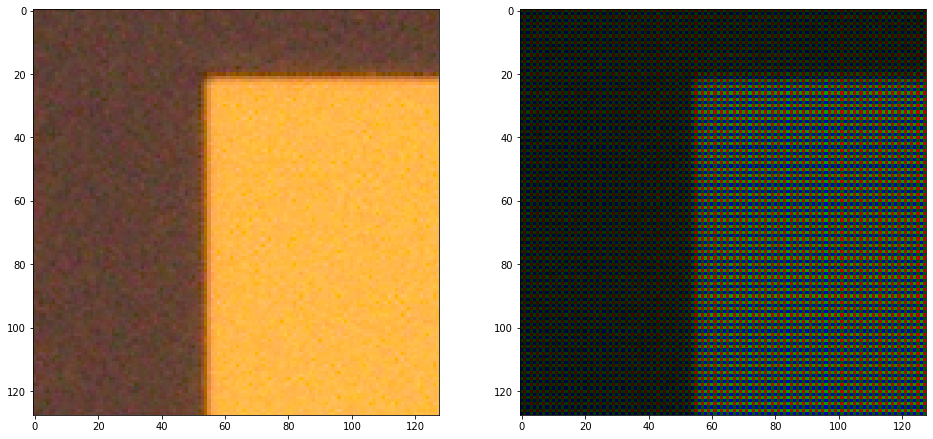

In [142]:
for i in image:
    srgb = tf.io.decode_raw(i['srgb'], 'uint8')
    raw  = tf.io.decode_raw(i['raw'], 'uint16')
    print(type(srgb), srgb.dtype, type(raw))
    srgb = tf.reshape(srgb, (128,128,3))
    raw  = tf.reshape(raw, (128,128, 1))
    
    srgb = tf.cast(srgb, tf.float32) / 255
    raw = tf.cast(raw, tf.float32) / (65535) 
    raw = raw**(1/2.2)
    
    raw = get_patternized_1ch_to_3ch_image(raw)
    print(srgb.shape, raw.shape)
    print(np.amin(raw), np.amax(raw))
    
    
    plt.figure(figsize=(16,16))
    plt.subplot(1,2,1)
    plt.imshow(srgb)
    plt.subplot(1,2,2) 
    plt.imshow(raw)
    plt.show()
    
#     break

In [76]:
crop_size = 128
cfa_pattern = 1

idx_R = np.tile(
            np.concatenate((np.concatenate((np.zeros((cfa_pattern, cfa_pattern)), np.ones((cfa_pattern, cfa_pattern))), axis=1),
                            np.concatenate((np.zeros((cfa_pattern, cfa_pattern)), np.zeros((cfa_pattern, cfa_pattern))), axis=1)), axis=0),
              (crop_size // 2 // cfa_pattern, crop_size // 2 // cfa_pattern))


idx_B = np.tile(
        np.concatenate((np.concatenate((np.zeros((cfa_pattern, cfa_pattern)), np.zeros((cfa_pattern, cfa_pattern))), axis=1),
                        np.concatenate((np.ones((cfa_pattern, cfa_pattern)), np.zeros((cfa_pattern, cfa_pattern))), axis=1)), axis=0),
          (crop_size // 2 // cfa_pattern, crop_size // 2 // cfa_pattern))

idx_G = np.tile(
        np.concatenate((np.concatenate((np.ones((cfa_pattern, cfa_pattern)), np.zeros((cfa_pattern, cfa_pattern))), axis=1),
                        np.concatenate((np.zeros((cfa_pattern, cfa_pattern)), np.ones((cfa_pattern, cfa_pattern))), axis=1)), axis=0),
          (crop_size // 2 // cfa_pattern, crop_size // 2 // cfa_pattern))

print(idx_R.shape)

(128, 128)


In [102]:
def get_patternized_1ch_to_3ch_image(image):

        dtype = tf.float32


        tf_R = tf.constant(idx_R[...,np.newaxis] , dtype=dtype)
        tf_G = tf.constant(idx_G[...,np.newaxis] , dtype=dtype)
        tf_B = tf.constant(idx_B[...,np.newaxis] , dtype=dtype)


        # non_shrink
        R  = tf.math.multiply(image, tf_R)
        G  = tf.math.multiply(image, tf_G)
        B  = tf.math.multiply(image, tf_B)
        
        print('-------------------> image.shape', image.shape)
        print('-------------------> R.shape', R.shape)



#         pattenrized = tf.concat((tf.expand_dims(R, axis=-1),
#                                  tf.expand_dims(G, axis=-1),
#                                  tf.expand_dims(B, axis=-1)),
#                                 axis=-1)
        pattenrized = tf.concat((R, G, B), axis=-1)
#         pattenrized = tf.concat((tf_R, tf_G, tf_B), axis=-1)

        return pattenrized

In [114]:
r = tf.random.normal([1])

InvalidArgumentError: shape must be a vector of {int32,int64}, got shape [] [Op:RandomStandardNormal]

In [111]:
r

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.0132891], dtype=float32)>

In [113]:
(r>0).numpy()

array([ True])